In [1]:
## Importing Libraries
import os
import numpy as np
import librosa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dropout

In [2]:
## Data Loading and Preprocessing
### Load Data
def load_data(test_size=0.2, chunk_duration=1):
    """
    Load audio data and corresponding labels from files.
    """
    x, y = [], []
    samples_dir = 'samples'  # Directory containing audio samples
    for file in os.listdir(samples_dir):
        try:
            # Load audio file
            audio, sample_rate = librosa.load(os.path.join(samples_dir, file), res_type='kaiser_fast')

            # Calculate number of chunks
            num_chunks = int(np.ceil(len(audio) / (sample_rate * chunk_duration)))

            # Extract features from each chunk
            for i in range(num_chunks):
                start = int(i * sample_rate * chunk_duration)
                end = min(len(audio), int((i + 1) * sample_rate * chunk_duration))
                chunk_audio = audio[start:end]

                # Extract features from audio chunk
                feature = extract_features_from_audio(chunk_audio, sample_rate)
                x.append(feature)

                # Extract class label from the file name
                class_label = file.split('(')[0]  # Assuming the class label is before the first '-'
                y.append(class_label)

        except Exception as e:
            print(f"Error processing file {file}: {str(e)}")

    # Encode the labels
    encoder = LabelEncoder()
    y = encoder.fit_transform(y)

    return train_test_split(np.array(x), y, test_size=test_size, random_state=42)

### Extract Features
def extract_features_from_audio(audio, sample_rate, mfcc=True, chroma=True, mel=True):
    """
    Extract features from audio using Librosa.
    """
    result = np.array([])
    if mfcc:
        mfccs = np.mean(librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40).T, axis=0)
        result = np.hstack((result, mfccs))
    if chroma:
        stft = np.abs(librosa.stft(audio))
        chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
        result = np.hstack((result, chroma))
    if mel:
        mel = np.mean(librosa.feature.melspectrogram(y=audio, sr=sample_rate).T, axis=0)
        result = np.hstack((result, mel))
    return result

## Model Creation and Training
### Create CNN Model
def create_cnn_model(input_shape, num_classes, dropout_rate=0.5):
    """
    Create a Convolutional Neural Network model.
    """
    model = models.Sequential()
    model.add(layers.Conv1D(64, 3, activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling1D(2))
    model.add(layers.Conv1D(128, 3, activation='relu'))
    model.add(layers.MaxPooling1D(2))
    model.add(layers.Conv1D(256, 3, activation='relu'))
    model.add(layers.MaxPooling1D(2))
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(layers.Dense(num_classes, activation='softmax'))
    return model

In [3]:
# Loading and Splitting the Dataset
X_train, X_test, y_train, y_test = load_data(test_size=0.2)

c:\Users\Ali\AppData\Local\Programs\Python\Python312\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1912
  warnings.warn(
c:\Users\Ali\AppData\Local\Programs\Python\Python312\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=70
  warnings.warn(


In [4]:
# Preparing Model Input Shape and Number of Classes
input_shape = (X_train.shape[1], 1)
num_classes = len(np.unique(y_train))

In [5]:
# Creating the CNN Model
cnn_model = create_cnn_model(input_shape=input_shape, num_classes=num_classes)

c:\Users\Ali\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [6]:
# Compiling the Model
cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [7]:
# Displaying Model Summary
cnn_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 178, 64)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 89, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 87, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 43, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 41, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 20, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 5120)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     2,621,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,747,524 (10.48 MB)

 Trainable params: 2,747,524 (10.48 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Training the Model
history = cnn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 190ms/step - accuracy: 0.3462 - loss: 2.4289 - val_accuracy: 0.5079 - val_loss: 1.1294
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.4512 - loss: 1.1326 - val_accuracy: 0.6667 - val_loss: 0.9428
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 0.5735 - loss: 1.0447 - val_accuracy: 0.7302 - val_loss: 0.7766
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.6382 - loss: 0.8160 - val_accuracy: 0.7778 - val_loss: 0.5603
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.7153 - loss: 0.6656 - val_accuracy: 0.8413 - val_loss: 0.4944
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 0.7903 - loss: 0.5555 - val_accuracy: 0.8968 - val_loss: 0.3890
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - accuracy: 0.7747 - loss: 0.5914 - val_accuracy: 0.8730 - val_loss: 0.3879
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - accuracy: 0.8078 - loss: 0.5302 - val_accuracy: 0.8

In [9]:
## Model Evaluation
### Evaluate the Model
test_loss, test_acc = cnn_model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9350 - loss: 0.2254
Test accuracy: 0.9285714030265808


In [10]:
y_pred_probs = cnn_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
f1 = f1_score(y_test, y_pred, average='weighted')
print('F1 Score:', f1)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step
F1 Score: 0.9290220901484219


In [11]:
### Generate ROC Curve
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_pred_probs[:, i])
    roc_auc[i] = roc_auc_score(y_test == i, y_pred_probs[:, i])

In [12]:
### Generate Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

Confusion Matrix:
[[24  0  0  1]
 [ 0 36  0  1]
 [ 0  0 25  4]
 [ 1  2  0 32]]


In [13]:
### Classification Report
print('Classification Report:')
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96        25
           1       0.95      0.97      0.96        37
           2       1.00      0.86      0.93        29
           3       0.84      0.91      0.88        35

    accuracy                           0.93       126
   macro avg       0.94      0.93      0.93       126
weighted avg       0.93      0.93      0.93       126



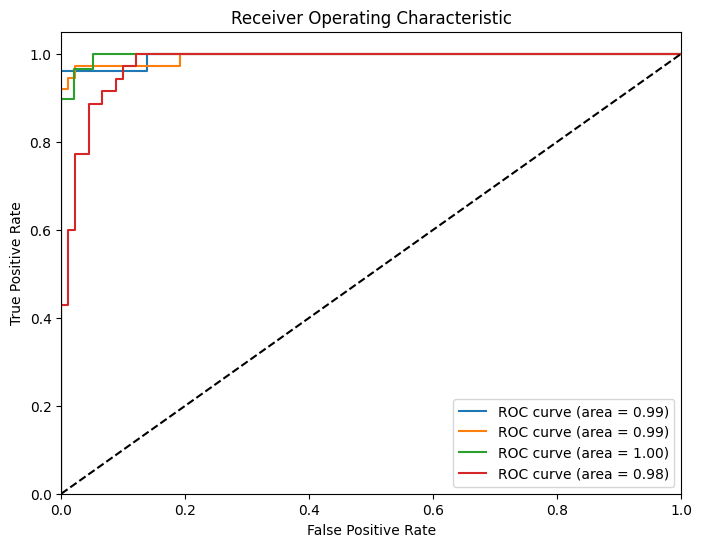

In [14]:
# Plotting Results
## Plotting ROC Curve
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

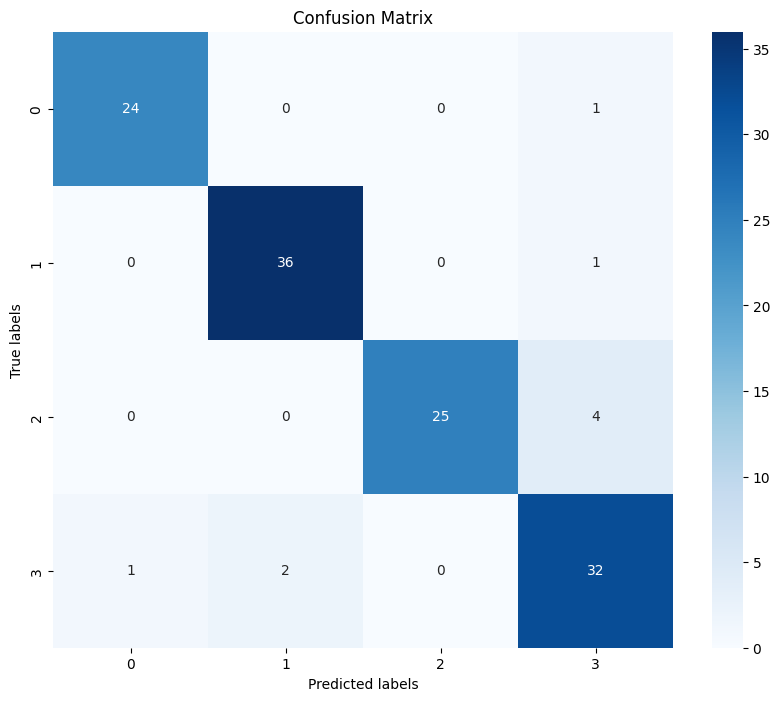

In [15]:
## Plotting Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()